<a href="https://colab.research.google.com/github/denisshaf/DSPractice/blob/DS-1.1/DQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[Practice DS 1.1] DQC and ETL

In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats, special

## MyDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ln -s '/content/drive/MyDrive' 'MyDrive'

## Download data

In [4]:
!pip install -q kaggle

In [5]:
! mkdir ~/.kaggle
! cp MyDrive/kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

 66% 10.0M/15.1M [00:00<00:00, 29.0MB/s]
100% 15.1M/15.1M [00:00<00:00, 43.1MB/s]


In [8]:
!unzip competitive-data-science-predict-future-sales -d data

Archive:  competitive-data-science-predict-future-sales.zip
  inflating: data/item_categories.csv  
  inflating: data/items.csv          
  inflating: data/sales_train.csv    
  inflating: data/sample_submission.csv  
  inflating: data/shops.csv          
  inflating: data/test.csv           


In [9]:
data = {}
for file in os.listdir('./data'):
  data[file[:-4]] = pd.read_csv(f'./data/{file}')

## Explore data

### File descriptions

- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

### Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### Show all data

In [ ]:
data['item_categories'].sample(10)

,item_category_name,item_category_id
14,Игровые консоли - PSVita,14
3,Аксессуары - PS4,3
73,Программы - 1С:Предприятие 8,73
76,Программы - Для дома и офиса (Цифра),76
18,Игры - PS2,18
23,Игры - XBOX 360,23
16,Игровые консоли - XBOX ONE,16
30,Игры PC - Стандартные издания,30
56,Музыка - CD фирменного производства,56
24,Игры - XBOX ONE,24


In [ ]:
data['items'].sample(10)

,item_name,item_id,item_category_id
12060,ИСТОРИЯ ДЕЛЬФИНА 2 (BD),12060,37
20359,"Фигурка Aliens Classic Warrior 7""",20359,72
14462,МАША И МЕДВЕДЬ: С Новым Годом! DVD+Открытка (В...,14462,40
11814,"Завтра война (Steam версия) [PC, Цифровая версия]",11814,31
2326,Call of Duty: Black Ops III. Nuketown Edition ...,2326,30
9232,Белянин Андрей Хватай Иловайского! (mp3-CD) (...,9232,43
12091,ИСЧЕЗНУВШАЯ (BD),12091,37
3940,"Inversion (СофтКлаб) [PC, Цифровая версия]",3940,31
12631,"КОЖА, В КОТОРОЙ Я ЖИВУ (BD)",12631,37
2319,Call of Duty: Black Ops II. Коллекционное изда...,2319,28


In [ ]:
data['sales_train'].head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [ ]:
data['sample_submission'].sample(10)

,ID,item_cnt_month
156470,156470,0.5
24539,24539,0.5
32657,32657,0.5
73570,73570,0.5
29127,29127,0.5
171221,171221,0.5
132937,132937,0.5
123667,123667,0.5
60349,60349,0.5
46721,46721,0.5


In [ ]:
data['shops'].head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [ ]:
data['test'].sample(10)

,ID,shop_id,item_id
17017,17017,3,701
14121,14121,6,3460
92314,92314,14,1413
118087,118087,53,13300
90545,90545,18,14846
75162,75162,21,14552
57629,57629,25,14075
6479,6479,4,20041
151753,151753,59,20903
48587,48587,31,18835


In [ ]:
data['shops'][data['shops']['shop_name'].apply(np.char.startswith, args=('!',))]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


### Duplicates

In [10]:
for name, data_set in data.items():
  is_duplicated = data_set.duplicated(keep=False)
  if is_duplicated.any():
    print(name)
    display(data_set[is_duplicated])

sales_train


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,05.01.2013,0,54,20130,149.0,1.0
76962,05.01.2013,0,54,20130,149.0,1.0
1435365,23.02.2014,13,50,3423,999.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496765,23.03.2014,14,21,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671872,01.05.2014,16,50,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866322,12.07.2014,18,25,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0


In [11]:
data['sales_train'][data['sales_train'].duplicated(subset=['item_id'])]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
8,11.01.2013,0,25,2572,299.0,1.0
11,05.01.2013,0,25,2574,399.0,1.0
12,07.01.2013,0,25,2574,399.0,1.0
13,08.01.2013,0,25,2574,399.0,2.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0


Дубликаты в `sales_train` - это норма, поэтому их удалиять не надо.

### Negative values

In [12]:
display(data['sales_train'][data['sales_train']['item_cnt_day'] <= 0]['item_cnt_day'].unique())

array([ -1.,  -5.,  -6.,  -3.,  -2.,  -4., -22., -16.,  -9.])

In [13]:
data['sales_train'].drop(data['sales_train'][data['sales_train']['item_cnt_day'] <= 0].index, inplace=True)
data['sales_train'].drop(data['sales_train'][data['sales_train']['item_price'] <= 0].index, inplace=True)

### Floats in item_cnt

In [14]:
data['sales_train'][~data['sales_train']['item_cnt_day'].apply(float.is_integer)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [15]:
data['sales_train']['item_cnt_day'] = data['sales_train']['item_cnt_day'].astype('int')

Количество товаров не может быть отрицательным, поэтому приведем их к `int`.

### Missing values

In [16]:
for name, data_set in data.items():
  print(name)
  display(pd.isna(data_set).any())
  print()

sample_submission


ID                False
item_cnt_month    False
dtype: bool


sales_train


date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool


test


ID         False
shop_id    False
item_id    False
dtype: bool


items


item_name           False
item_id             False
item_category_id    False
dtype: bool


item_categories


item_category_name    False
item_category_id      False
dtype: bool


shops


shop_name    False
shop_id      False
dtype: bool

Пропусков нет.

### Outliers

Выбросы могут быть в `item_price` и `item_cnt_day`.

In [20]:
data_length = len(data['sales_train'])
data_length

2812607

Выбросы будем искать с помощью inter quantile distance

In [21]:
len(data['sales_train'])

2812607

#### `item_price`

##### Нетрансформированная переменная

<Axes: xlabel='item_price', ylabel='Count'>

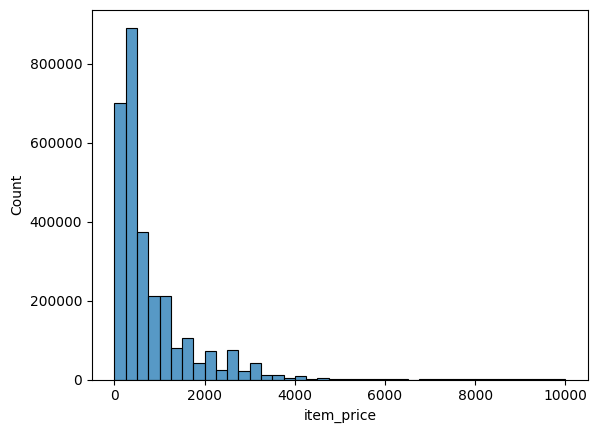

In [ ]:
sns.histplot(data['sales_train']['item_price'][data['sales_train']['item_price'] < 10000], bins=40)

In [ ]:
q25, q75 = np.quantile(data['sales_train']['item_price'], [.25, .75])
iqd = q75 - q25

outliers = data['sales_train']['item_price'][(data['sales_train']['item_price'] < (q25 - 1.5 * iqd)) |
                                             (data['sales_train']['item_price'] > (q75 + 1.5 * iqd))]
print(f'Границы отрезка: {q25 - 1.5 * iqd, q75 + 1.5 * iqd}')
print(f'Число выбросов: {len(outliers)}')
print(f'Процент выбросов: {len(outliers) / data_length}')

Границы отрезка: (-876.0, 2124.0)
Число выбросов: 257555
Процент выбросов: 0.08794799507732991


8% процентов выбросов - многовато.

##### Трансформация Бокса-Кокса

Так как у `item_price` явно не нормальное распределение, а удаление выбросов с помощью IQR обычно применяется к нормальным распределениям, лучше сначала применить трансформацию Бокса-Кокса.

In [ ]:
boxcox_transformed, lambda_ = stats.boxcox(data['sales_train']['item_price'])
q25, q75 = np.quantile(boxcox_transformed, [.25, .75])
iqd = q75 - q25

outliers = boxcox_transformed[#(boxcox_transformed < (q25 - 1.5 * iqd)) |
                              (boxcox_transformed > (q75 + 1.5 * iqd))]
borders = special.inv_boxcox([q25 - 1.5 * iqd, q75 + 1.5 * iqd], lambda_)

print(f'Границы отрезка: {borders[0], borders[1]}')
print(f'Число выбросов: {len(outliers)}')
print(f'Процент выбросов: {len(outliers) / data_length}')

Границы отрезка: (20.0901891477619, 5948.211346795105)
Число выбросов: 29967
Процент выбросов: 0.01023291168287296


1% выбросов - маловато.

Объекты в левом интервале выбросами считать не будем, т. к. дешевые товары - это вполне нормально.

<Axes: ylabel='Count'>

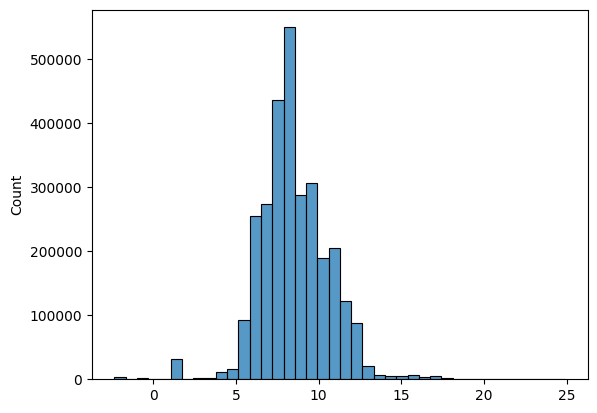

In [ ]:
sns.histplot(boxcox_transformed, bins=40)

##### `sqrt`

In [22]:
sqrt_transformed = data['sales_train']['item_price'].apply(np.sqrt)
q25, q75 = np.quantile(sqrt_transformed, [.25, .75])
iqd = q75 - q25

outliers = sqrt_transformed[(sqrt_transformed < (q25 - 1.5 * iqd)) |
                            (sqrt_transformed > (q75 + 1.5 * iqd))]

borders = q25 - 1.5 * iqd, q75 + 1.5 * iqd
print(f'Границы отрезка (в преобразованной величине): {borders}')
print(f'Границы отрезка: {0, np.square(borders[1])}')
print(f'Число выбросов: {len(outliers)}')
print(f'Процент выбросов: {len(outliers) / data_length}')

Границы отрезка (в преобразованной величине): (-5.5256584565461, 51.2887209957355)
Границы отрезка: (0, 2630.5329013784)
Число выбросов: 55631
Процент выбросов: 0.019779158624009682


3% выбросов - нормальное количество, их и выбросим. Получается, что выбросами будем считать товары с ценой > 3000.

<Axes: xlabel='item_price', ylabel='Count'>

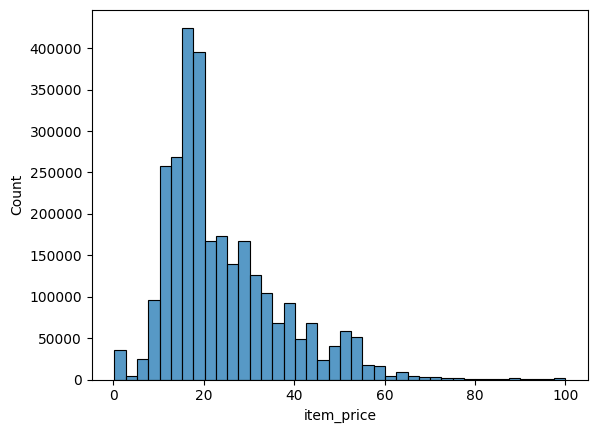

In [ ]:
sns.histplot(sqrt_transformed[sqrt_transformed < 100], bins=40)

In [23]:
data['sales_train'].drop(data['sales_train'][data['sales_train']['item_price'] > np.square(borders[1])].index,
                         inplace=True)

#### `item_cnt_day`

<Axes: xlabel='item_cnt_day', ylabel='Count'>

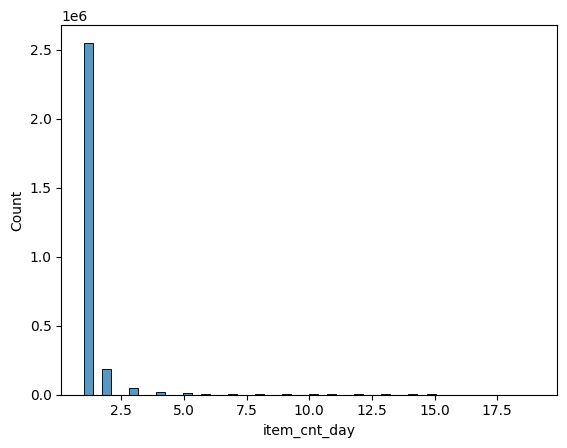

In [ ]:
sns.histplot(data['sales_train']['item_cnt_day'][data['sales_train']['item_cnt_day'] < 20], bins=50)

Все преобразования дают отрезок [q25 - 1.5 * IQD, q75 + 1.5 * IQD] равный [1.0, 1.0], поэтому посмотрим на гистограмму и удалим выбросы на глаз.

In [ ]:
len(data['sales_train']['item_cnt_day'][data['sales_train']['item_cnt_day'] > 5])

25926

In [19]:
data['sales_train'].drop(data['sales_train'][data['sales_train']['item_cnt_day'] > 5].index,
                         inplace=True)

### Normalization

In [24]:
data['sales_train']['item_price'] = (data['sales_train']['item_price'] - data['sales_train']['item_price'].mean()) / data['sales_train']['item_price'].std()
data['sales_train']['item_cnt_day'] = (data['sales_train']['item_cnt_day'] - data['sales_train']['item_cnt_day'].mean()) / data['sales_train']['item_cnt_day'].std()